In [61]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [62]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITHOUT_ISTIO_WITHOUT_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 3
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}
CURRENT_RUN = 0

In [63]:
# Get the json data for all the runs in a list
def get_runs():
    runs = []
    for run_data in os.listdir(PARSED_OUTPUTS):
        with open(os.path.join(PARSED_OUTPUTS, run_data), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs

In [64]:
# For a given run, get total time spent in all functions.
def get_total_time_all_functions(run, recurse=False):
    time = {}

    def get_time(function, time, recurse):
        func_name = function["function_name"].strip().strip(";")

        if func_name not in FUNC_BLACKLIST:
            time[func_name] = time.get(func_name, 0) + function["time"]
        if recurse:
            for child in function["children"]:
                get_time(child, time, recurse)
    
    for pid in run:
        for function in run[pid]:
            get_time(function, time, recurse)
        
    return time


In [65]:
def plot_time(time, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(time))
    x = sorted(list(time.keys()), key=lambda x: time[x], reverse=True)[ :maxnum]
    y = [time[_] for _ in x]


    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

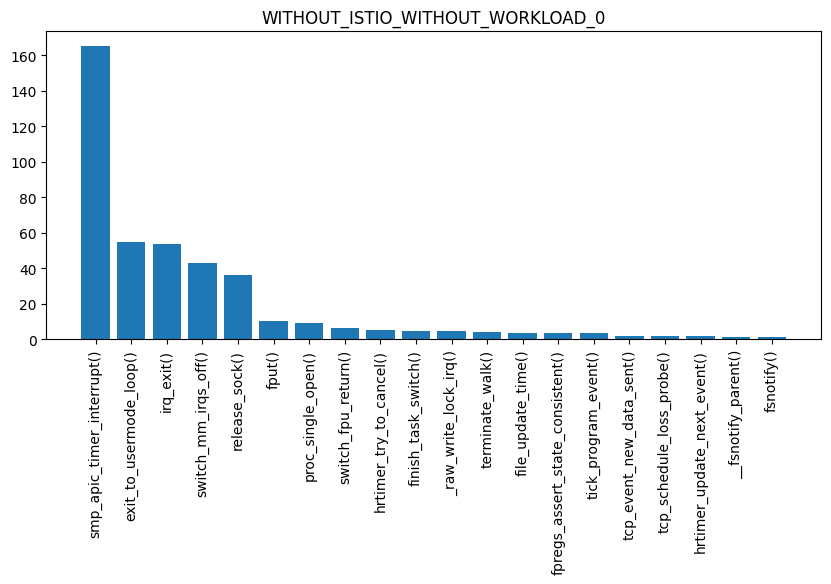

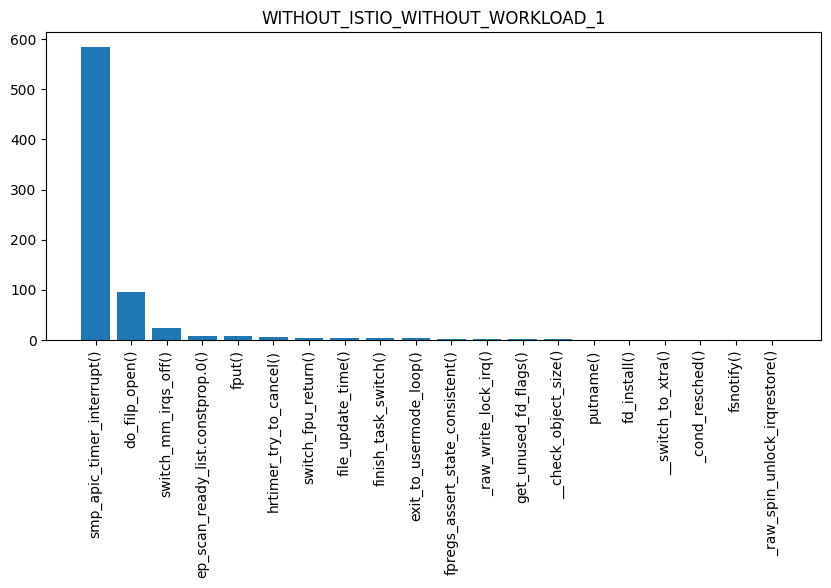

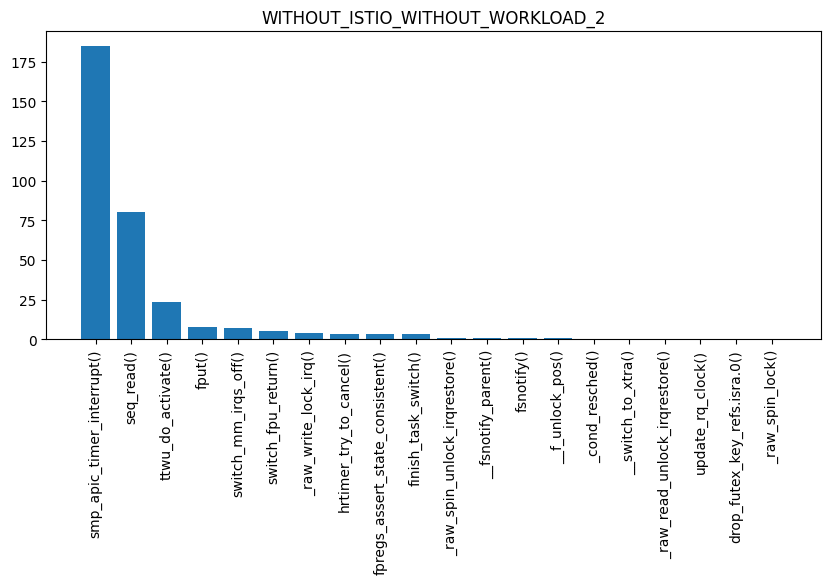

In [66]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_total_time_all_functions(runs[i])
    plot_time(count, title=f"{WORKLOAD}_{i}")

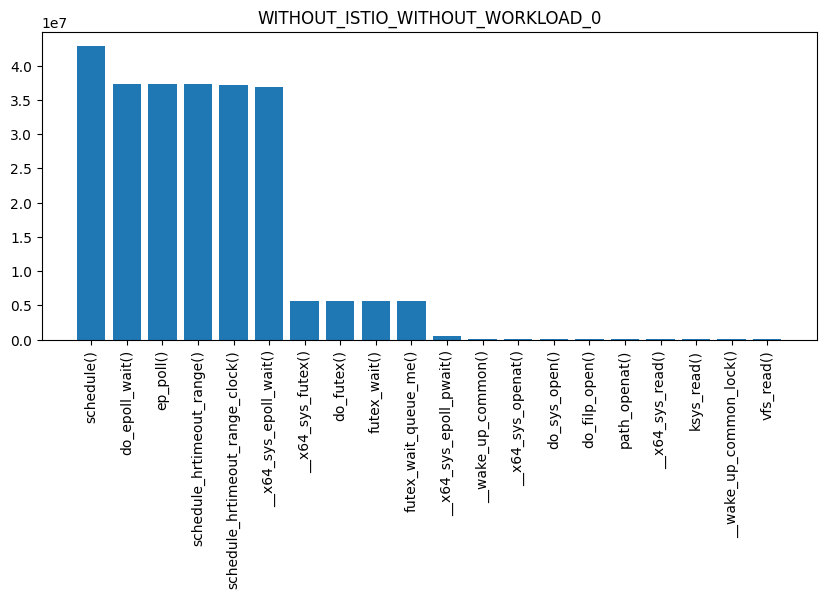

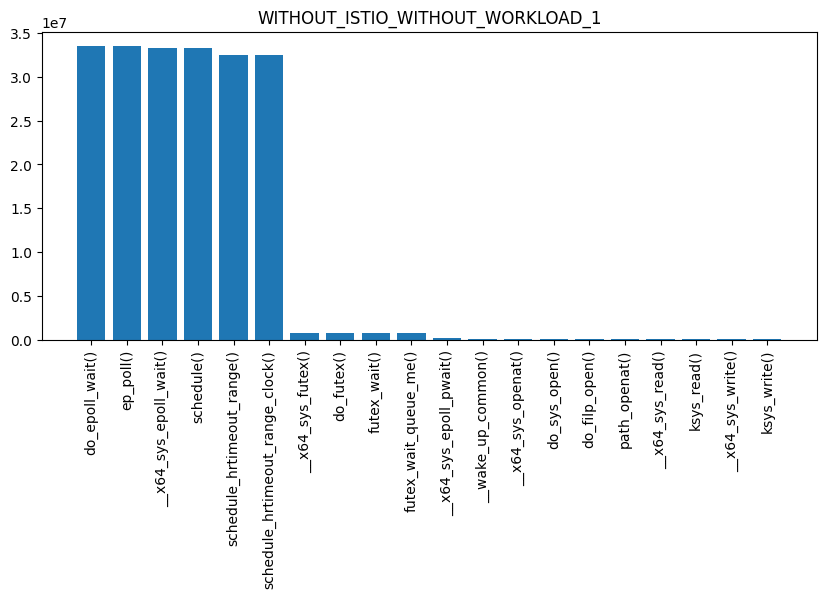

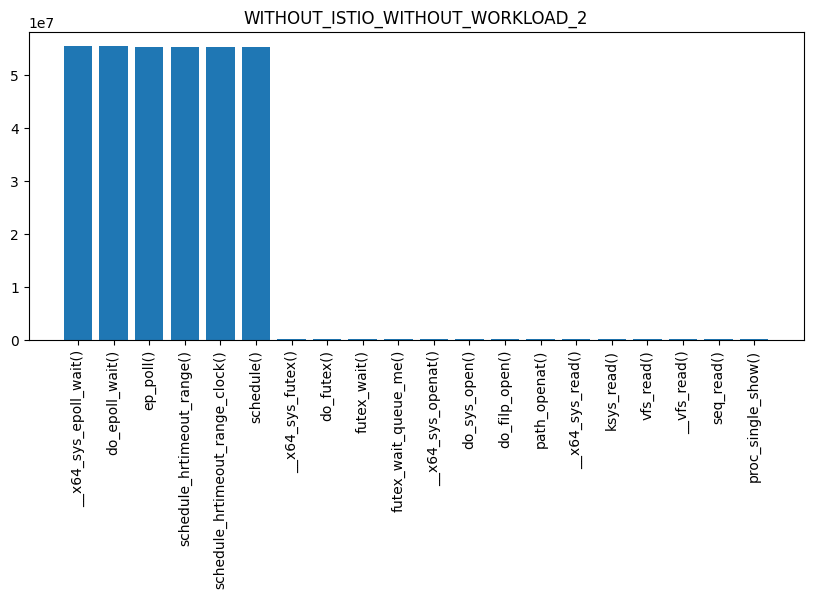

In [67]:
for i in range(NUM_RUNS):
    count = get_total_time_all_functions(runs[i], recurse=True)
    plot_time(count, title=f"{WORKLOAD}_{i}")

In [70]:
def is_leaf_node(function):
    return len(function["children"]) == 0

# Check if a leaf node at one instance can be a non leaf node at another
def check_leaf_assumption(run):
    non_leaf_nodes = set()
    leaf_nodes = set()

    def check_leaf(function):
        func_name = function["function_name"].strip().strip(";")

        if is_leaf_node(function):
            leaf_nodes.add(func_name)
        else:
            non_leaf_nodes.add(func_name)
            for child in function["children"]:
                    check_leaf(child)
    
    for pid in run:
        for function in run[pid]:
            check_leaf(function)
        
    return non_leaf_nodes.intersection(leaf_nodes)

In [71]:
check_leaf_assumption(runs[0])

{'__account_cfs_rq_runtime()',
 '__fget_light()',
 '__local_bh_enable_ip()',
 '__update_idle_core()',
 '__update_load_avg_blocked_se()',
 '__update_load_avg_cfs_rq()',
 '__update_load_avg_se()',
 '_raw_spin_lock()',
 '_raw_spin_lock_irqsave()',
 '_raw_spin_unlock_irqrestore()',
 'aa_file_perm()',
 'activate_task()',
 'bbr_cwnd_event [tcp_bbr]()',
 'check_preempt_curr()',
 'consume_skb()',
 'enqueue_task_fair()',
 'finish_task_switch()',
 'follow_managed()',
 'fput_many()',
 'generic_permission()',
 'in_group_p()',
 'kfree()',
 'kfree_skbmem()',
 'kmem_cache_free()',
 'migrate_task_rq_fair()',
 'mod_timer()',
 'nf_conntrack_in [nf_conntrack]()',
 'note_gp_changes()',
 'psi_task_change()',
 'resched_curr()',
 'reweight_entity()',
 'select_idle_sibling()',
 'select_idle_sibling.part.0()',
 'seq_put_decimal_ll()',
 'skb_release_data()',
 'skb_release_head_state()',
 'switch_mm_irqs_off()',
 'task_dump_owner()',
 'tcp_event_data_recv()',
 'tcp_queue_rcv()',
 'tcp_rearm_rto()',
 'tcp_schedul